<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# EDA

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# A
#Check size of dataset~(1460, 81)
house.shape

#Check for duplicate values~None
house.duplicated().value_counts()

#Check for null values
house.isnull().sum()

#Describe to get overview
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


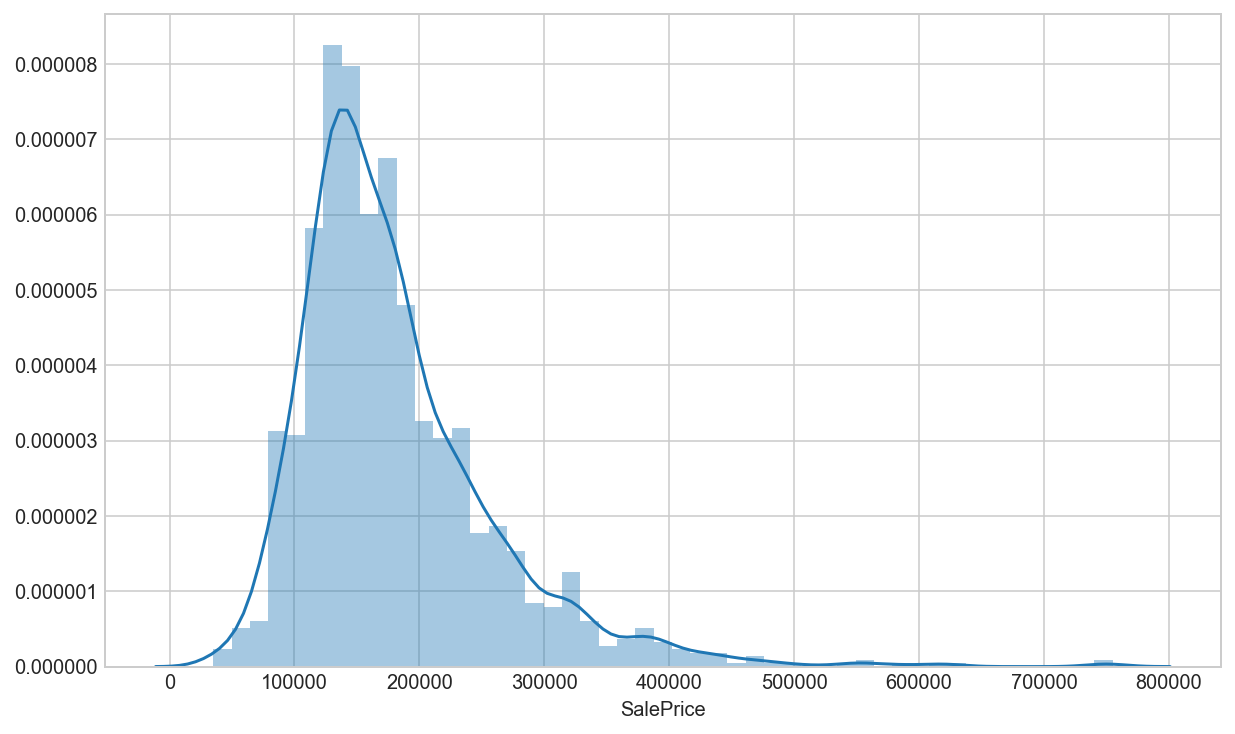

In [4]:
#Check out SalePrice distribution~This shows a right skew, should we transform it?No better to transform predictors itself
plt.figure(figsize=(10,6))
sns.distplot(house['SalePrice'])
plt.show()

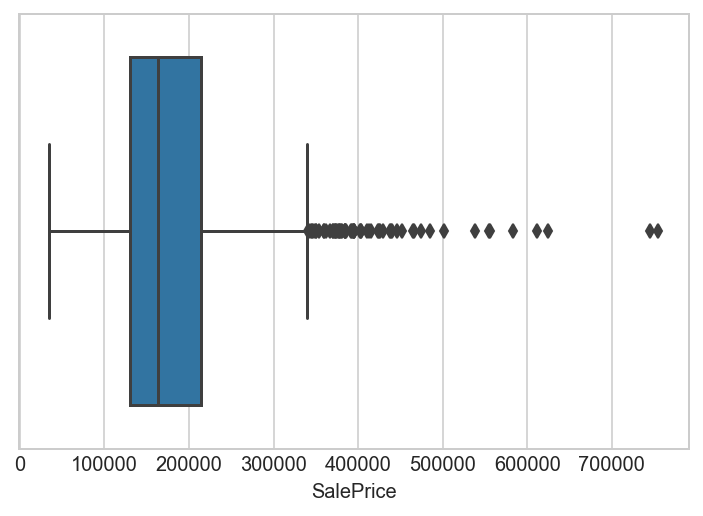

In [5]:
#Check out outliers that we may wish to drop~Do we wnat to drop?Must explore further
sns.boxplot(house['SalePrice']);

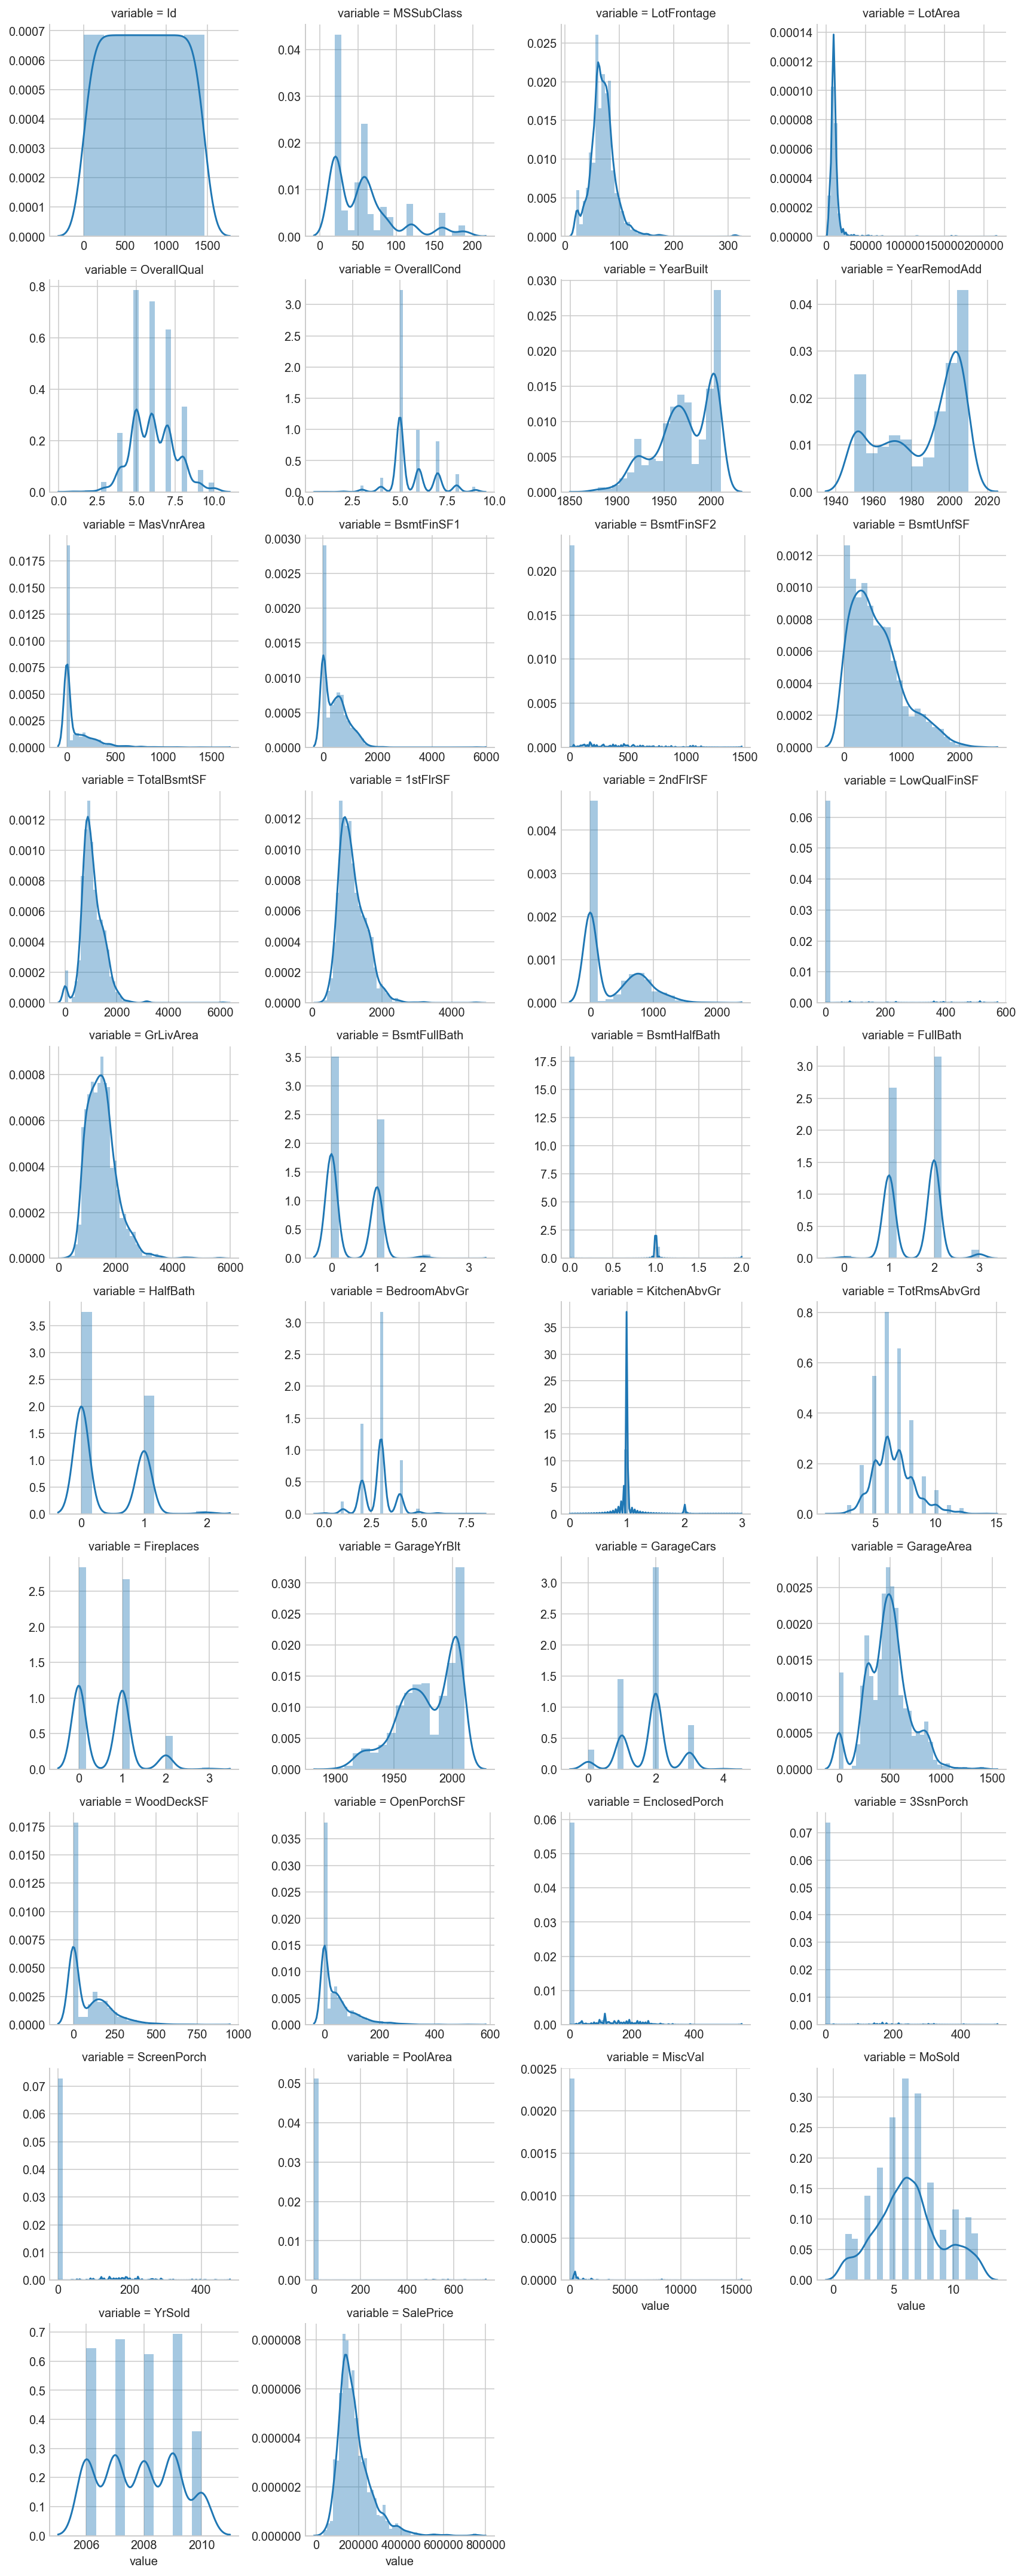

In [6]:
#Check out distribution for continuous features
continuous_house = house.select_dtypes('number')
f = pd.melt(continuous_house)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

C:\Users\Tan Kian How\Anaconda2\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


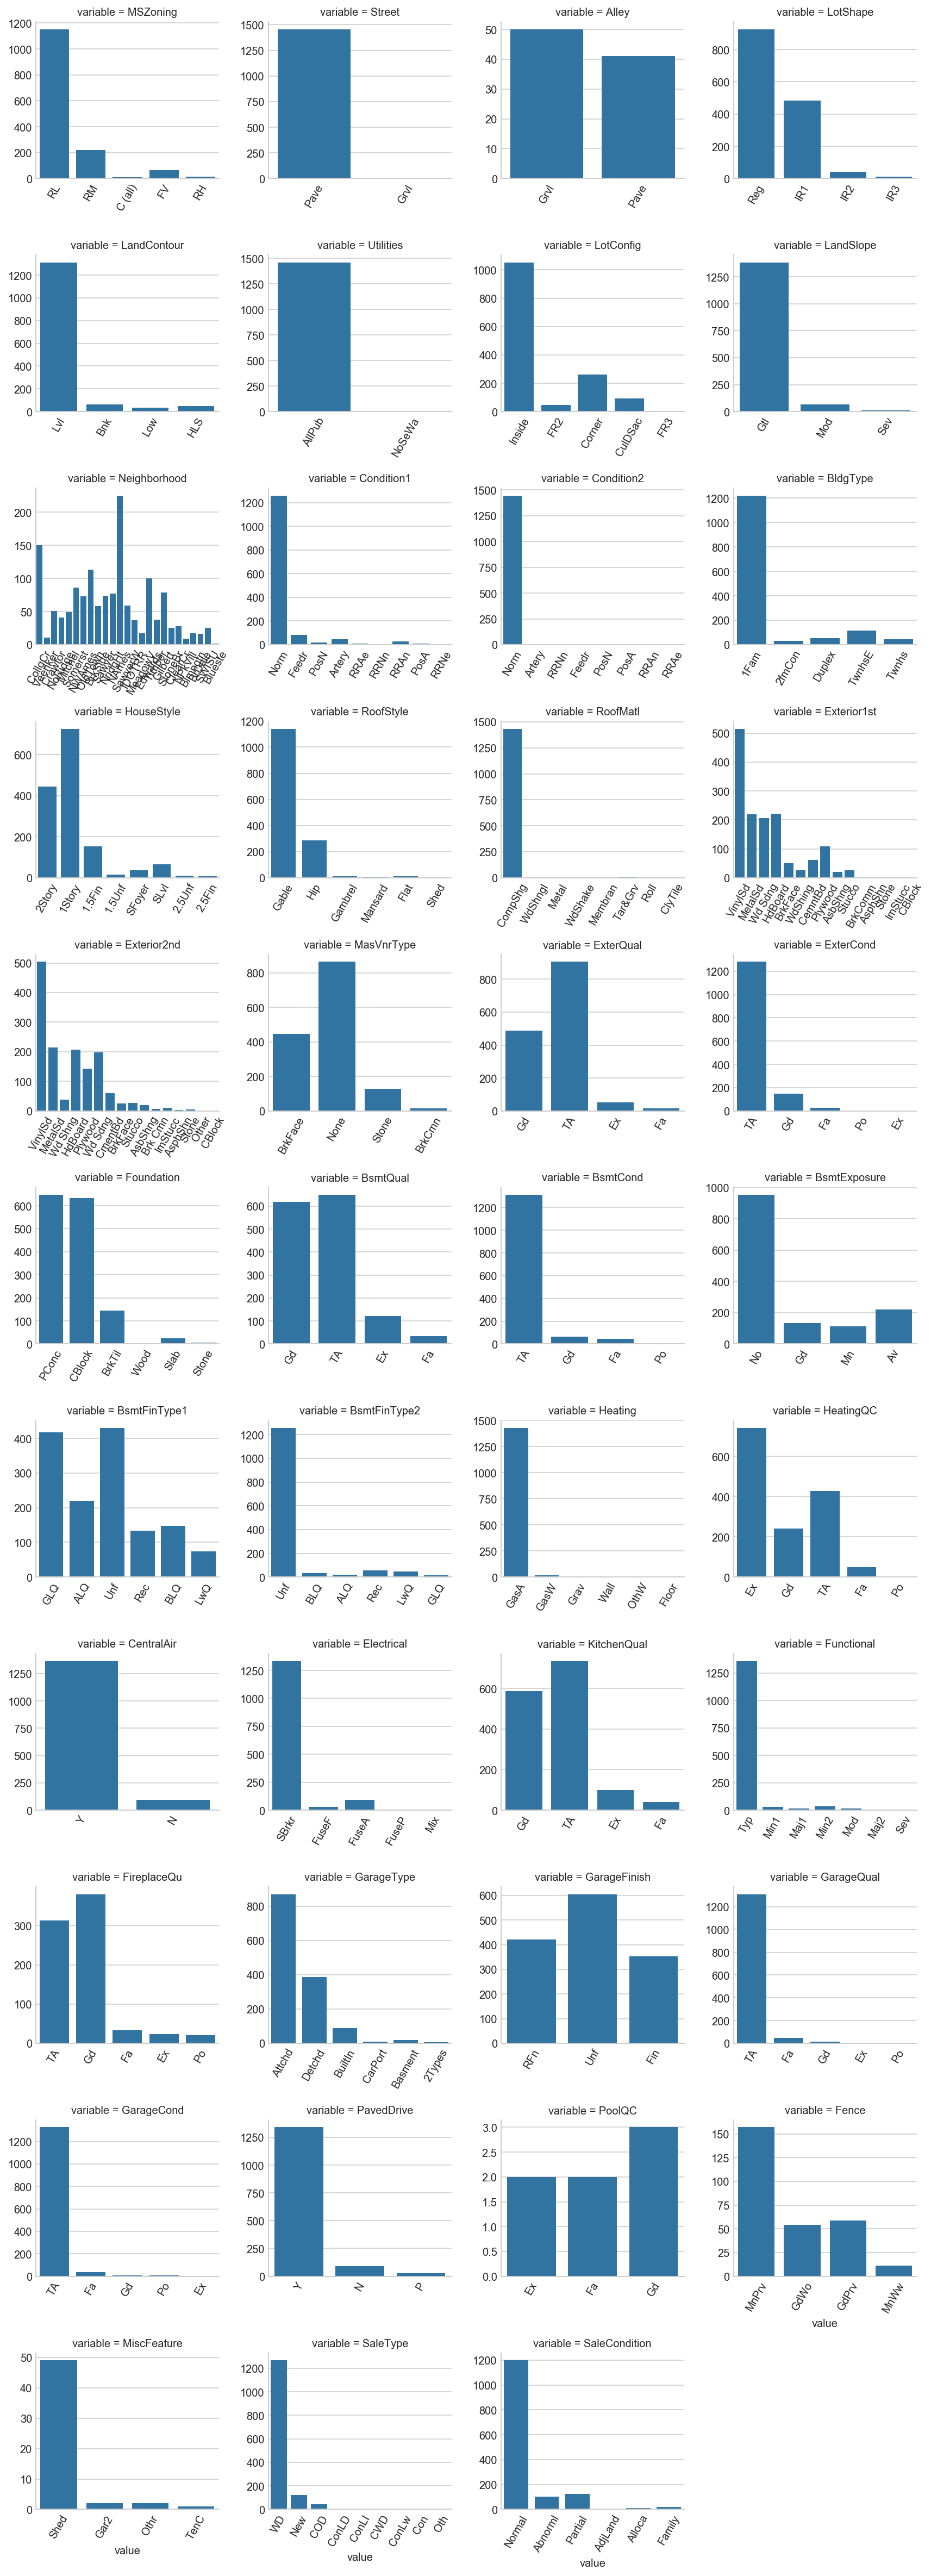

In [7]:
#Check out distribution for catogorical features
catogorical_house = house.select_dtypes('object')
f = pd.melt(catogorical_house)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

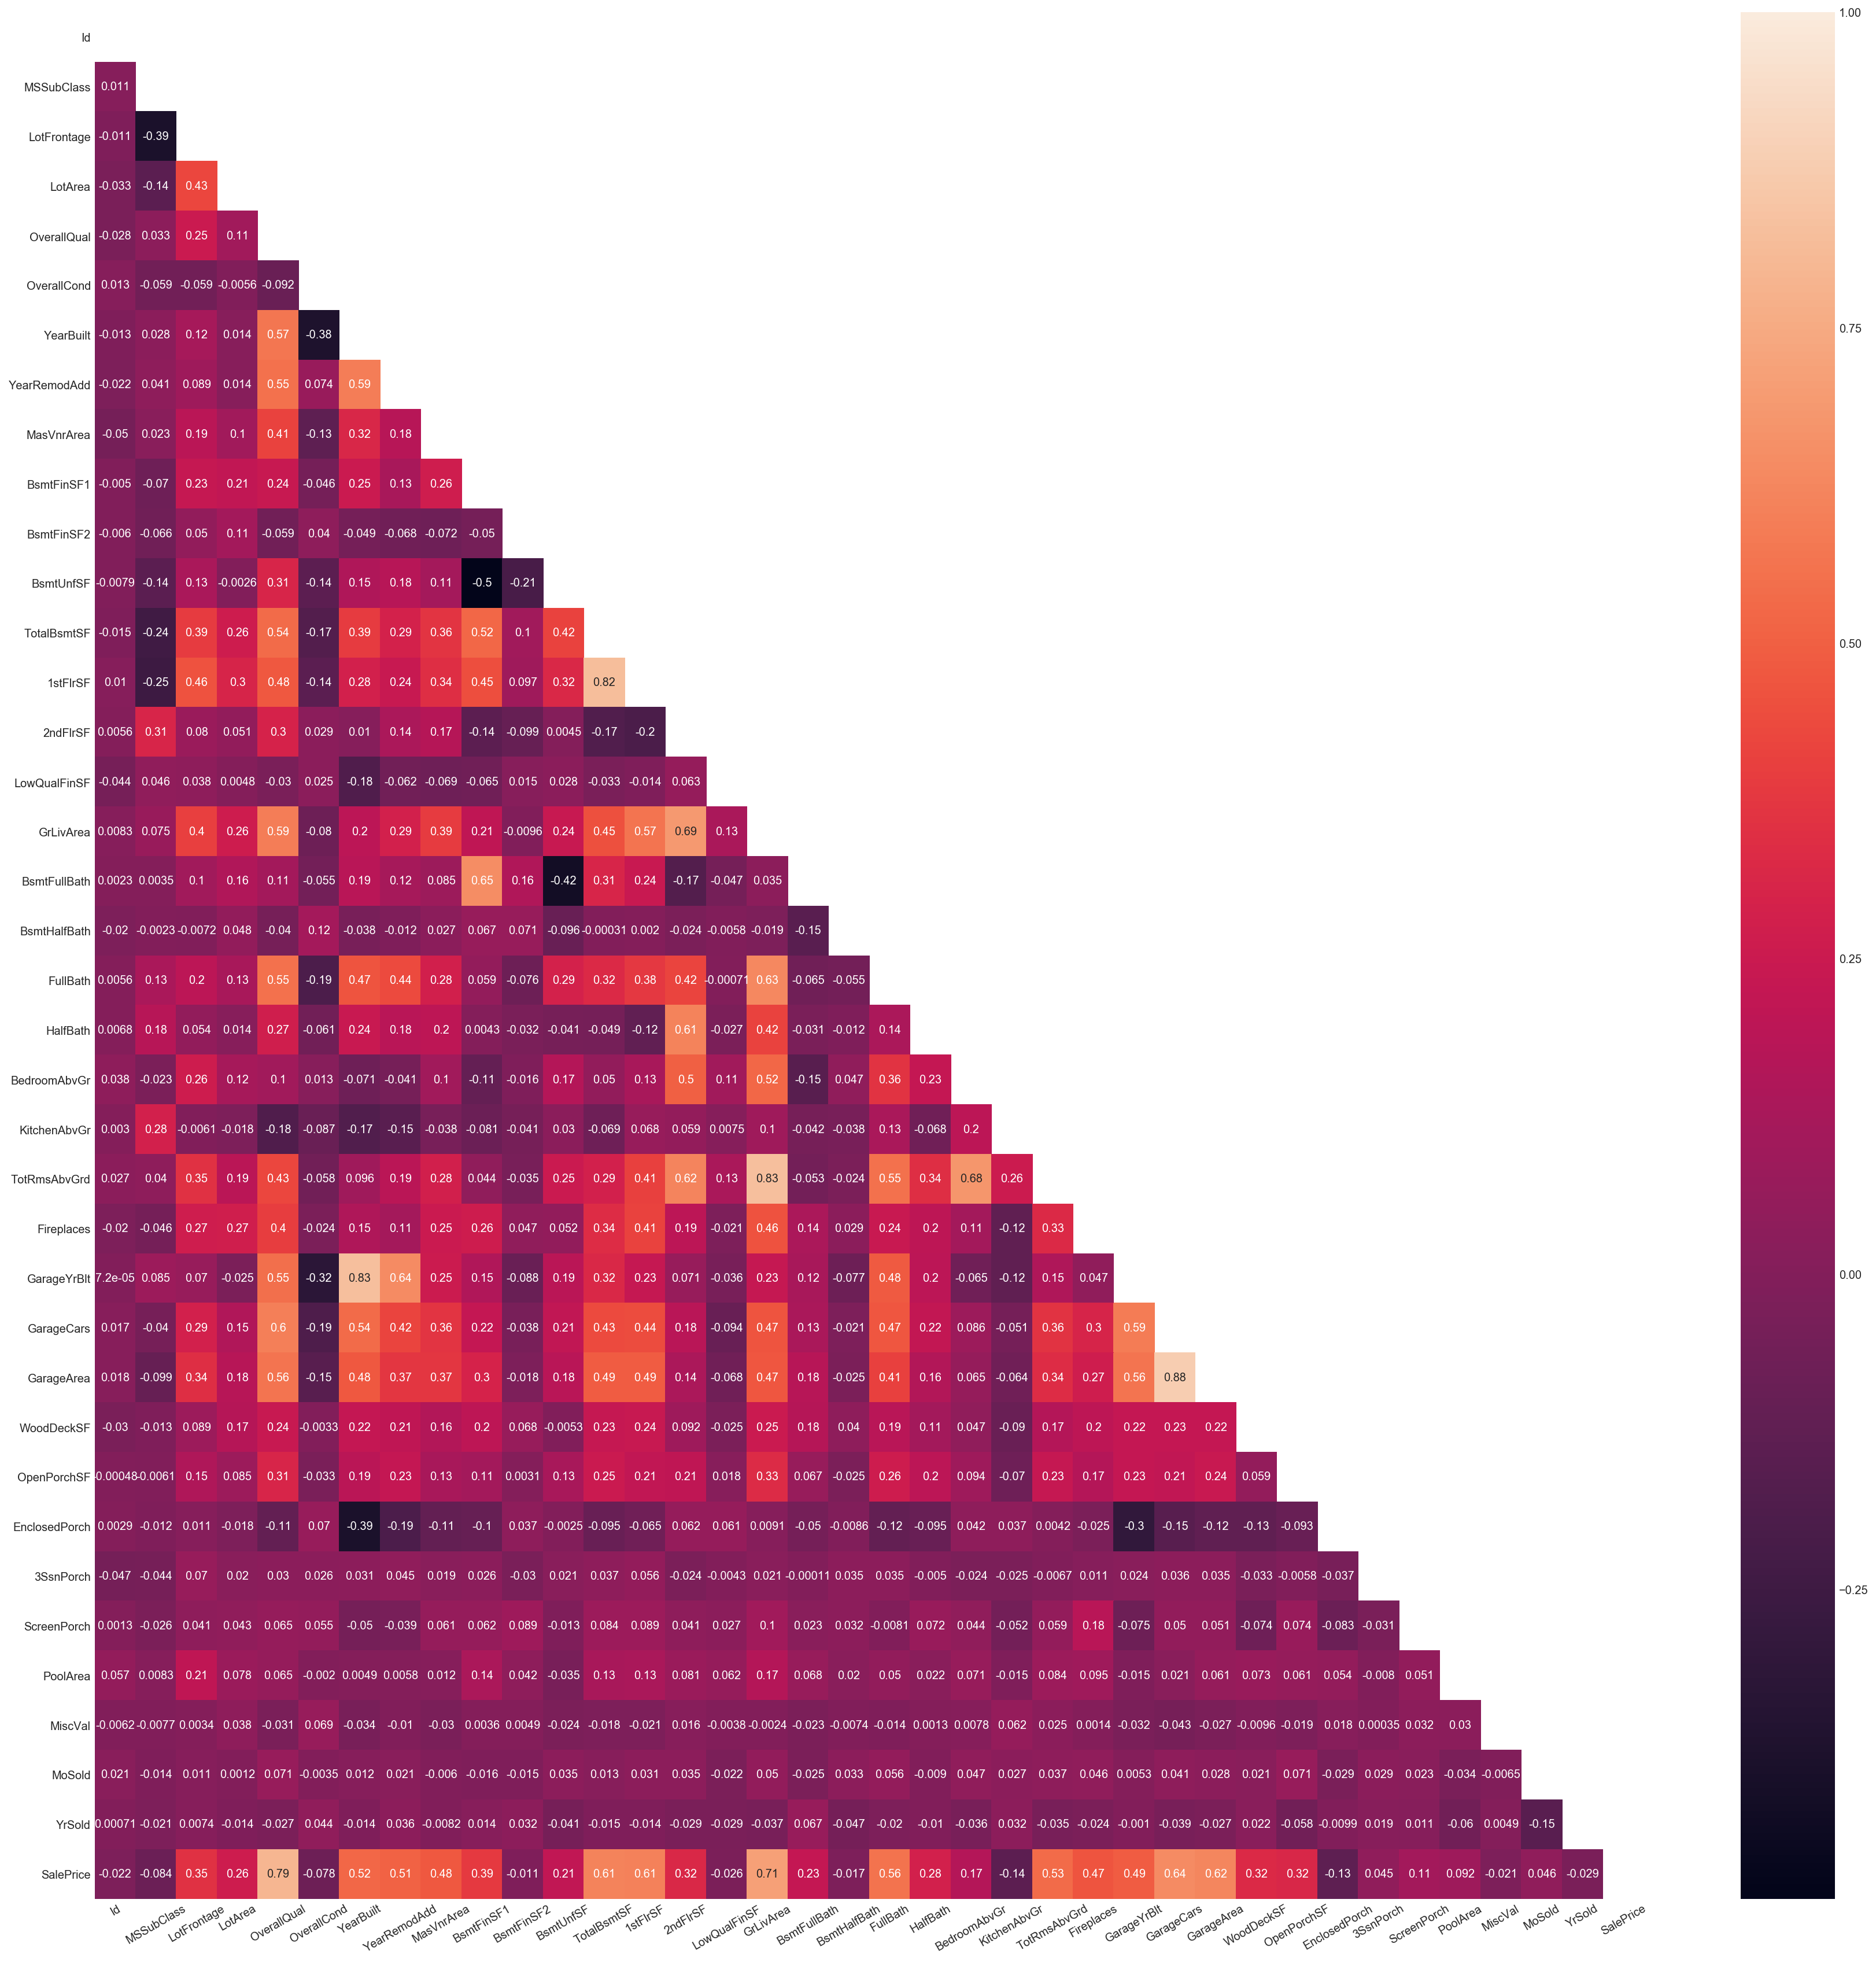

In [8]:
#Plot heatmap to check out correlation
def correlation_heat_map(df):
    corrs = house.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(30,30))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

correlation_heat_map(house)


## 1) Dumb Model by Univariate Feature Selection

I have identified a few **fixed** features with correlation abv 0.5

1) GrLivArea: Above grade (ground) living area square feet<br>
2) TotalBsmtSF: Total square feet of basement area<br>
3) 1stFlrSF: First Floor square feet<br>
4) FullBath: Full bathrooms above grade<br>
5) TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)<br>
6) GarageArea: Size of garage in square feet (GarageCars: Size of garage in car capacity due to high corr)<br><br>


Also I have identified a few **fixed** features that may have a relationship with price, that needs to be dummycoded<br>
1) LotShape: General shape of property<br>
2) LandContour: Flatness of the property<br>
3) LotConfig: Lot configuration<br>
4) Neighborhood: Physical locations within Ames city limits

**1a) Dummycode**

In [9]:
#Create a dataframe for these features(Include YrSold so that can split later)
model_one_df = house[['LotShape', 'LandContour', 'LotConfig', 'Neighborhood',\
                      'SalePrice', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF','FullBath',\
                      'TotRmsAbvGrd','GarageArea','YrSold']]

In [10]:
#Change dtype of yrsold from int to str to allow it to be dummycoded
house['YrSold'] = house['YrSold'].astype(str)


In [11]:
#Dummycode the features and append
dummy_df = pd.get_dummies(house[['LotShape', 'LandContour', 'LotConfig', 'Neighborhood','YrSold']],drop_first = True)
model_one_df_dummied = pd.concat([model_one_df,dummy_df],axis =1)
model_one_df_dummied.drop(['LotShape', 'LandContour', 'LotConfig', 'Neighborhood'],axis =1,inplace= True)
model_one_df_dummied.shape

(1460, 46)

**1b) Train-Test_Split**

In [12]:
#Split data by year for train and test data
#Call our traintest sets as F1(Meaning featureselection1)

F1Train_X = model_one_df_dummied[model_one_df_dummied['YrSold'] < 2010].drop(['SalePrice','YrSold'],axis =1)
F1Test_X = model_one_df_dummied[model_one_df_dummied['YrSold'] == 2010].drop(['SalePrice','YrSold'],axis =1)
F1Train_y = model_one_df_dummied[model_one_df_dummied['YrSold'] < 2010]['SalePrice']
F1Test_y = model_one_df_dummied[model_one_df_dummied['YrSold'] == 2010]['SalePrice']



print 'TrainX Shape:', F1Train_X.shape
print 'TestX Shape:', F1Test_X.shape
print 'Trainy Shape:', F1Train_y.shape
print 'Testy Shape:', F1Test_y.shape


TrainX Shape: (1285, 44)
TestX Shape: (175, 44)
Trainy Shape: (1285L,)
Testy Shape: (175L,)


In [13]:
#Standardize all our predictors for both our train and test set
from sklearn.preprocessing import StandardScaler
F1Standardized_Train_X = StandardScaler().fit_transform(F1Train_X)
F1Standardized_Test_X = StandardScaler().fit_transform(F1Test_X)

**1c) Check out how univariate feature selection performs for linear regression**

In [14]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

#Perform  10 cross-validation
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, F1Standardized_Train_X, F1Train_y, cv= 10)
print '10 fold Training accuracy scores: ',scores, 'Mean: ', scores.mean()


#Perform the prediction
lm.fit(F1Standardized_Train_X, F1Train_y)
predictions = lm.predict(F1Test_X)

#Get the score of prediction
print 'Predicted R2 scores:', lm.score(F1Standardized_Test_X, F1Test_y)

10 fold Training accuracy scores:  [0.82397776 0.82576226 0.81657233 0.7358943  0.75237364 0.79165708
 0.75329396 0.73728386 0.49657044 0.81071643] Mean:  0.7544102058749413
Predicted R2 scores: 0.8063444993021021


C:\Users\Tan Kian How\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


** Conclusion: This Seems alright, lets try to improve it**

### 2) Try Regularization on all fixed features for feature selection

**I would need to do a more thorough cleaning as compared to my first 2 models whose features were chosen univariately.**

In [15]:
#Check the null values
house_null_values = pd.DataFrame(house.isna().sum())
house_null_values.columns = ['Count of null values']
house_null_values['%'] = house_null_values['Count of null values']/1460 *100
print house_null_values[house_null_values['Count of null values']>0]

              Count of null values          %
LotFrontage                    259  17.739726
Alley                         1369  93.767123
MasVnrType                       8   0.547945
MasVnrArea                       8   0.547945
BsmtQual                        37   2.534247
BsmtCond                        37   2.534247
BsmtExposure                    38   2.602740
BsmtFinType1                    37   2.534247
BsmtFinType2                    38   2.602740
Electrical                       1   0.068493
FireplaceQu                    690  47.260274
GarageType                      81   5.547945
GarageYrBlt                     81   5.547945
GarageFinish                    81   5.547945
GarageQual                      81   5.547945
GarageCond                      81   5.547945
PoolQC                        1453  99.520548
Fence                         1179  80.753425
MiscFeature                   1406  96.301370


**Explore**<br> 

1) LotFrontage: Linear feet of street connected to property ~ It seems to relate to the size of the lot hence it does not seem like it can be 0.,<br>Thus we either drop it and rely on other measures like lot area, or we inpute null values with mean values. After checking correlation and plotting the distribution(right skewed) of Lotfrontage excluding nan values, i think its more appropriate to fillna with median

2) Alley: Type of alley access to property ~ Gravel,pavement or no access. 94% has no alleys, so just make this into a new column containing alley/no alley

3) FireplaceQu: Fireplace quality~ Excellent, Good ,Average ,Fair ,Poor ,Nan = 'No Fireplace'

4) PoolQC: Pool quality ~ Excellent, Good, Average/, Fair, NA = 'No Pool'
       
5) Fence: Fence quality ~ Good Privacy, Minimum Privacy, Good Wood, Minimum Wood/Wire, na = 'No Fence'
	
6) MiscFeature: Miscellaneous feature not covered in other categories ~ Elevator, 2nd Garage (if not described in garage section), Other, Shed (over 100 SF), Tennis Court, NA = 'None'

**For 3- 6: As these features make up a big chunk. i feel that ranking it may not have much effect. encode 1s and 0s again**

7) 5 features describing garage with 81 null vlaues. Input strings 'No garage'


8) MasVnrType: Masonry veneer type: None is inputed as none, hence if na, put to none,By extension MasVnrArea na can replace with 0 

9) Input strings no Bsmt ~ BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 

10) Electrical, replace with highest count~SBrkr


**We leave the rest of the columns that have no null values as it is**

In [16]:
#We use house2 as our cleaned dataframe after dealing with nullvalues
house2 = house.copy()

#Cleaned Lotfrontage
house2['LotFrontage'] = house['LotFrontage'].fillna(house['LotFrontage'].median())

#Cleaned Alley,PoolQC ,Fence,MiscFeature,FireplaceQu
house2[['Alley','PoolQC','Fence','MiscFeature','FireplaceQu']] = house2[['Alley','PoolQC','Fence','MiscFeature','FireplaceQu']] .notna().astype(int)

# Cleaned GarageType, GarageFinish, GarageQual, GarageCond 
house2[[ 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt']] = house[[ 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt']].fillna('No Garage')

#Cleaned MasVnrType
house2['MasVnrType'] = house2['MasVnrType'].fillna('None')

# Cleaned MasVnrArea
house2['MasVnrArea'] = house2['MasVnrArea'].fillna(0)

#Cleaned Basements
house2[[ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'  ]] = house[[ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' ]].fillna('No Bsmt')

#Cleaned Electrical
house2['Electrical'] = house2['Electrical'].fillna('SBrkr ')

In [17]:
#We use house2 as our cleaned dataframe


#Check out catogorical and continuous features
house2_catogorical = house2.select_dtypes('O')
house2_continuous = house2.select_dtypes('number')
print 'Original Catogorical', house2_catogorical.columns , house2_catogorical.shape
print 'Original Continuous', house2_continuous.columns, house2_continuous.shape


# #Drop stupid columns like 'Id' from continuous
house2_continuous = house2_continuous.drop('Id',axis =1)


# #Change misclassified features 
Continuous_to_Catogorical_list = ['MSSubClass', 'OverallQual', 'OverallCond',\
                                   'OverallCond', 'YearBuilt', 'YearRemodAdd',\
                                    'MoSold']

#Get final Catogorical and Continuous Features
house2_catogorical_final = pd.concat([house2_catogorical,house2_continuous[Continuous_to_Catogorical_list]],axis =1)
house2_continuous_final = house2_continuous.drop(Continuous_to_Catogorical_list,axis =1)

print 'Final Catogorical', house2_catogorical_final.columns, house2_catogorical_final.shape
print 'Final Continuous', house2_continuous_final.columns, house2_continuous_final.shape


#Concat them togther for final dataset
house2= pd.concat([house2_catogorical_final,house2_continuous_final],axis =1)
print house2.shape

Original Catogorical Index([u'MSZoning', u'Street', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'ExterQual',
       u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'KitchenQual', u'Functional',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageQual',
       u'GarageCond', u'PavedDrive', u'YrSold', u'SaleType', u'SaleCondition'],
      dtype='object') (1460, 40)
Original Continuous Index([u'Id', u'MSSubClass', u'LotFrontage', u'LotArea', u'Alley',
       u'OverallQual', u'OverallCond', u'YearBuilt', u'YearRemodAdd',
       u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLiv

In [18]:
#Recheck for null values
#house2 is cleaned after removing nulls

#Check the null values
house2_null_values = pd.DataFrame(house2.isna().sum())
house2_null_values.columns = ['count of null values']
house2_null_values['%'] = house2_null_values['count of null values']/1460 *100
print house2_null_values[house2_null_values['count of null values']>0]

Empty DataFrame
Columns: [count of null values, %]
Index: []


**Split features into renovatable and fixed**

In [19]:
#My renovatable list
#I define renovatable items as items that can be easily remodeled. This includes their accompanying features like yearRemodAdd
#Features that are in place are deemed as unrenovatable as i assume owners are attracted to them. For example, size of porch,availability of fireplace
#While owners can renovate to icnrease the area, we assume none will be done.

renovatable_list = ['Street', 'Alley', 'Utilities', 'OverallQual',\
                    'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',\
                    'Exterior2nd', 'MasVnrType', 'ExterQual',\
                    'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure',\
                    'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF',\
                    'Heating', 'HeatingQC', 'CentralAir', 'Electrical',\
                    'LowQualFinSF', 'KitchenQual', 'Functional',\
                    'FireplaceQu', 'GarageYrBlt', 'GarageFinish',\
                    'GarageQual', 'GarageCond', 'PavedDrive',\
                   'PoolQC', 'Fence','OverallCond']

fixed_list = house2.drop(renovatable_list,axis =1)
fixed_list.shape

(1460, 46)

In [20]:
#dummycode all fixed features that are catogorical in nature, after which we concat back the fixed features that are continuous

#Get Fixed catogorical features
fixed_catogorical = fixed_list.select_dtypes('O')

#Dummy-code fixed catogorical features
dummied_fixed_catogorical = pd.get_dummies(fixed_catogorical,drop_first = True)
print 'Total fixed catogorical after dummycoding:', dummied_fixed_catogorical.shape


#Get Fixed continuous features
fixed_continuous = fixed_list.select_dtypes('number')
print 'Total fixed continuous: ', fixed_continuous.shape

#Get Total fixed dataset 
fixed_catogorical_continuous = pd.concat([dummied_fixed_catogorical,fixed_continuous],axis =1)

print 'Total fixed dataset:', fixed_catogorical_continuous.shape

Total fixed catogorical after dummycoding: (1460, 93)
Total fixed continuous:  (1460, 31)
Total fixed dataset: (1460, 124)


**Train-Test-Split**

In [21]:
#Split our dataset Predictors(X) and target(y)
X = fixed_catogorical_continuous.drop('SalePrice',axis =1)
y = fixed_catogorical_continuous['SalePrice']

#Input Yrsold for us to split data, we can drop it later
toconcat = house2['YrSold'].astype(int)
X2 = pd.concat([X,toconcat],axis =1)

#Standardize predictors
from sklearn.preprocessing import StandardScaler
SX = StandardScaler().fit_transform(X2)

#Make our final trainset and test set for target and predictors,remember to drop yrsold
F2Train_X = X2[X2['YrSold'].astype(int) < 2010].drop('YrSold',axis =1)
F2Test_X = X2[X2['YrSold'].astype(int) == 2010].drop('YrSold',axis =1)
F2Train_y = house2[house2['YrSold'].astype(int) < 2010]['SalePrice']
F2Test_y = house2[house2['YrSold'].astype(int) == 2010]['SalePrice']


print 'TrainX Shape:', F2Train_X.shape
print 'TestX Shape:', F2Test_X.shape
print 'Trainy Shape:', F2Train_y.shape
print 'Testy Shape:', F2Test_y.shape

TrainX Shape: (1285, 123)
TestX Shape: (175, 123)
Trainy Shape: (1285L,)
Testy Shape: (175L,)


**Lasso with gridsearched hyperparameter**

In [22]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
#Apply lasso
# #Setting alpha to 0 will be equal to ordinary least squares,hence i should achieve the same result.Apply best alpha after gridsearch
ls = Lasso(alpha = 150) # Found that 720 was the optimal after gridsearch

#10 cross-validation on lasso
lsscore = cross_val_score(ls, F2Train_X, F2Train_y, cv= 10)
print '10 fold Training accuracy scores: ',lsscore, 'Mean: ', lsscore.mean()


#Perform the prediction
ls.fit(F2Train_X, F2Train_y)
predictions = ls.predict(F2Test_X)

#Get the score of prediction
print 'Predicted R2 scores:', ls.score(F2Test_X, F2Test_y)

C:\Users\Tan Kian How\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 fold Training accuracy scores:  [0.8914538  0.84469376 0.85426814 0.74526155 0.83480952 0.80197256
 0.8589786  0.81245524 0.44114488 0.8402876 ] Mean:  0.7925325654289651
Predicted R2 scores: 0.8726611536651432


In [23]:
#Find the predictors chosen by lasso, whcih arecoefs bigger than 0
chosen_predictors_coef= ls.fit(F2Train_X,F2Train_y).coef_ 
predictors = F2Train_X.columns

predictor_with_score = zip(predictors, chosen_predictors_coef)
df =pd.DataFrame(predictor_with_score,columns = ['predictors', 'coefs'])

#Predictors coefs bigger than 0
df[df['coefs']>0]
print 'Total predictors used:', len(df[df['coefs']>0]), 'Percentage used: ', float(len(df[df['coefs']>0])) / (len(df['coefs']))

Total predictors used: 42 Percentage used:  0.341463414634


In [24]:
#Try hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV
alpha = [140,150,175,180,190]

params = dict(alpha = alpha)
ls_grid_search = GridSearchCV(Lasso(),params,cv =10,verbose =1 )
ls_grid_search.fit(F2Train_X, F2Train_y)

#Get the best score
print 'best_score:', ls_grid_search.best_score_

#Get best estimator
best_estimator = ls_grid_search.best_estimator_
print 'best estimator', best_estimator


predictions = ls_grid_search.predict(F2Test_X)
print 'predicted R2 with best hyperparamter:', ls_grid_search.score(F2Test_X, F2Test_y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
best_score: 0.792694296122275
best estimator Lasso(alpha=150, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
predicted R2 with best hyperparamter: 0.8726611536651432


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.1s finished


**Apply Ridge with hyperparamter tuning**

In [25]:
#Apply ridge
# #Setting alpha to 0 will be cause it to have wierd results, eg: to set small feagures, use 0.001
rs = Ridge(alpha = 5)

#10 cross-validation on Ridge
rsscore = cross_val_score(rs, F2Train_X, F2Train_y, cv= 10)
print '10 fold Training accuracy scores: ',rsscore, 'Mean: ', rsscore.mean()


#Perform the prediction
rs.fit(F2Train_X, F2Train_y)
predictions = rs.predict(F2Test_X)

#Get the score of prediction
print 'Predicted R2 scores:', rs.score(F2Test_X, F2Test_y)

#Try hyperparameter tuning for Ridge
from sklearn.model_selection import GridSearchCV
alpha = [1,3,5,7,10]

params = dict(alpha = alpha)
rs_grid_search = GridSearchCV(Ridge(),params,cv =10,verbose =1 )
rs_grid_search.fit(F2Train_X, F2Train_y)

#Get the best score
print 'best_score:', rs_grid_search.best_score_

#Get best estimator
best_estimator = rs_grid_search.best_estimator_
print 'best estimator', best_estimator


predictions = rs_grid_search.predict(F2Test_X)
print 'predicted R2 with best hyperparamter:', rs_grid_search.score(F2Test_X, F2Test_y)

10 fold Training accuracy scores:  [0.89693132 0.84844394 0.85183532 0.73719917 0.83899635 0.8284964
 0.85864367 0.80876638 0.49300449 0.83617159] Mean:  0.7998488623159099
Predicted R2 scores: 0.8753165684959858
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best_score: 0.7999843967781171
best estimator Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
predicted R2 with best hyperparamter: 0.8753165684959858


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


**Apply elastic net with hyperparmeter tuning**

In [26]:
#Apply Elastic Net
# #Setting alpha to 0 will be cause it to have wierd results, eg: to set small feagures, use 0.001
en = ElasticNet(alpha = 0.001)

#10 cross-validation on Ridge
enscore = cross_val_score(en, F2Train_X, F2Train_y, cv= 10)
print '10 fold Training accuracy scores: ',enscore, 'Mean: ', enscore.mean()


#Perform the prediction
en.fit(F2Train_X,F2Train_y)
predictions = en.predict(F2Test_X)

#Get the score of prediction
print 'Predicted R2 scores:', en.score(F2Test_X, F2Test_y)

#Try hyperparameter tuning for Elastoc Net
from sklearn.model_selection import GridSearchCV
alpha = [0,0.1,0.2,0.5]
l1_ratio =[0.1,0.2,0.7,0.9]

params = dict(alpha = alpha, l1_ratio = l1_ratio)
en_grid_search = GridSearchCV(ElasticNet(),params,cv =10,verbose =1 )
en_grid_search.fit(F2Train_X, F2Train_y)

#Get the best score
print 'best_score:', en_grid_search.best_score_

#Get best estimator
best_estimator = en_grid_search.best_estimator_
print 'best estimator', best_estimator


predictions = en_grid_search.predict(F2Test_X)
print 'predicted R2 with best hyperparamter:', en_grid_search.score(F2Test_X, F2Test_y)

10 fold Training accuracy scores:  [0.89152141 0.84067565 0.84538947 0.73481888 0.84253618 0.7705462
 0.85459852 0.80539138 0.50492124 0.81391108] Mean:  0.7904310016985049
Predicted R2 scores: 0.8733468199551876
Fitting 10 folds for each of 16 candidates, totalling 160 fits


C:\Users\Tan Kian How\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tan Kian How\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


best_score: 0.7981010037892564
best estimator ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
predicted R2 with best hyperparamter: 0.8743742441593164


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   15.2s finished


**Conclusion: My Ridge,Lasso and Elastic Net all scored around the same for training set. Hence, i can choose either one. I decide to go with Lasso as I do not want to deal with so many features**

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

**Lets check out the price variance unexplained by fixed features **

In [27]:
#Find residuals
predicted_price_test= ls_grid_search.predict(F2Test_X)
actual_price_test = F2Test_y.values
residuals_test = predicted_price_test - actual_price_test

#Percentage diff
percentage = residuals_test/actual_price_test *100


In [28]:
df =pd.DataFrame({'Predicted': predicted_price_test,\
                  'Actual_2010_price': actual_price_test,\
                  'Difference in $' : residuals_test,\
                 'Percentage diff': percentage})

df.head()

,Actual_2010_price,Difference in $,Percentage diff,Predicted
0,149000,11989.038505,8.046335,160989.038505
1,154000,-8527.447940,-5.537304,145472.552060
2,134800,-12784.568522,-9.484101,122015.431478
3,306000,11073.449163,3.618774,317073.449163
4,165500,14458.550784,8.736284,179958.550784


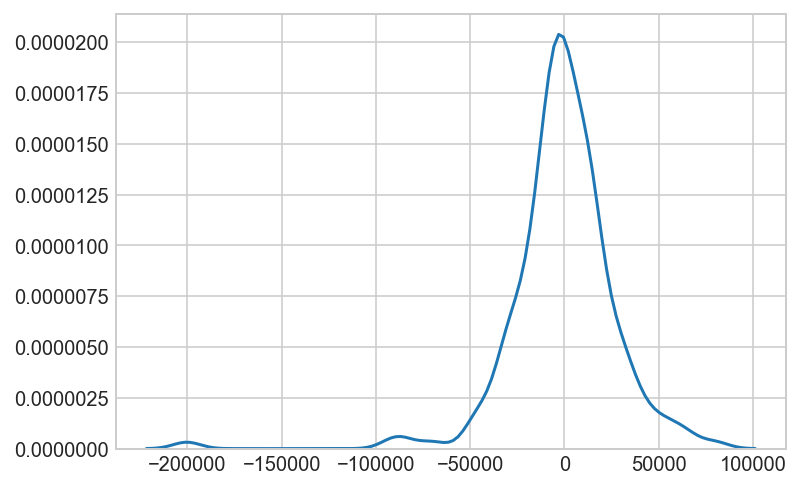

In [29]:
#plot residuals distribution
sns.kdeplot(residuals_test);

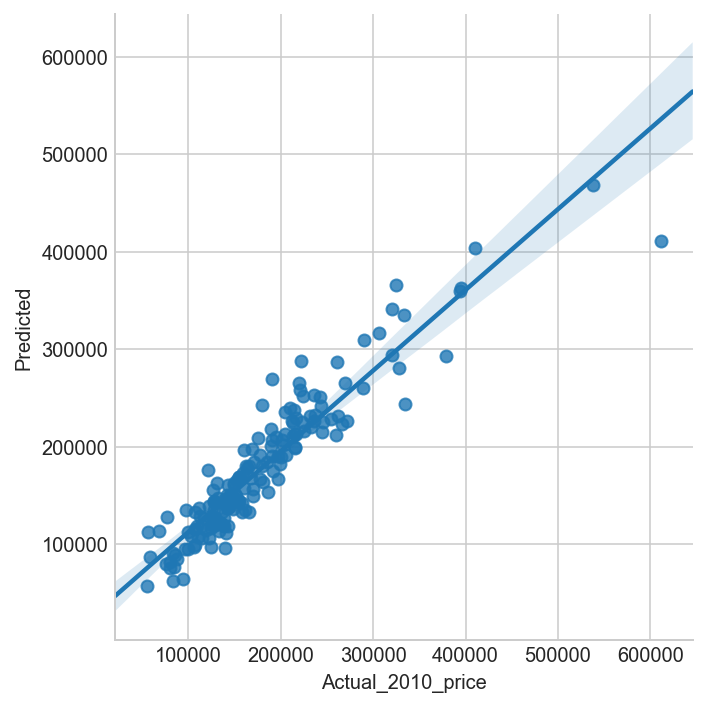

In [30]:
#Compare real and predicted
sns.lmplot(x='Actual_2010_price', y='Predicted', data =df );

**Use my renovatable features(X) to predict the residuals(y)**<br>
Hence, we find our residuals train and test s

In [31]:
#Find my residuals---> predicted price using my lasso model minus originalprice in test set
#TrainSet
predicted_price_train= ls_grid_search.predict(F2Train_X)
actual_price_train = F2Train_y.values


#TestSet
predicted_price_test= ls_grid_search.predict(F2Test_X)
actual_price_test = F2Test_y.values

#Residuals(y)
residuals_train = predicted_price_train - actual_price_train
residuals_test = predicted_price_test - actual_price_test

**Split my renovatable features into into catogorical and continous to allow us to dummycode,then concatenate them back togther to form our X**

In [32]:
#Split into catogorical and continuous renovatable
print house2.shape
print 'Renovatble_list: ',renovatable_list
catogorical_renovatable = house2[renovatable_list].select_dtypes('O')
continuous_renovatable = house2[renovatable_list].select_dtypes('number')

print catogorical_renovatable.columns
print continuous_renovatable.columns

(1460, 81)
Renovatble_list:  ['Street', 'Alley', 'Utilities', 'OverallQual', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'OverallCond']
Index([u'Street', u'Utilities', u'RoofStyle', u'RoofMatl', u'Exterior1st',
       u'Exterior2nd', u'MasVnrType', u'ExterQual', u'ExterCond',
       u'Foundation', u'BsmtCond', u'BsmtExposure', u'BsmtFinType1',
       u'BsmtFinType2', u'Heating', u'HeatingQC', u'CentralAir', u'Electrical',
       u'KitchenQual', u'Functional', u'GarageYrBlt', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive'],
      dtype='object')
Index([u'Alley', u'OverallQual', u'YearRemodAdd', u'BsmtUnfSF',
      

In [33]:
#Get dummies for catogorical
renovatable_dummy_df = pd.get_dummies(catogorical_renovatable,drop_first =True,)
print 'Catogorical renovatable after dummy:', renovatable_dummy_df.shape


#Join catogorical and continuous
house4 = pd.concat([renovatable_dummy_df,continuous_renovatable],axis =1)


#house4 = 'All renovatable catogorical and continuous + Yrsold 
#Add Yearsold so that we can split by year later
house4 = pd.concat([house4, house[['YrSold']]],axis =1)
print 'Total Size of dataset after dummycoding(catagorical + continuous): ', house4.shape



#Get the train data, and drop yearsold after using it to split data
F3Train_X = house4[house4['YrSold'].astype(int) < 2010].drop(['YrSold'],axis =1)
F3Test_X = house4[house4['YrSold'].astype(int) == 2010].drop(['YrSold'],axis =1)

#Get testdata
F3Train_y = residuals_train
F3Test_y =residuals_test

print F3Train_X.shape
print F3Test_X.shape
print F3Train_y.shape
print F3Test_y.shape

Catogorical renovatable after dummy: (1460, 214)
Total Size of dataset after dummycoding(catagorical + continuous):  (1460, 225)
(1285, 224)
(175, 224)
(1285L,)
(175L,)


**Build my Lasso and tune its hyperparameters**

In [34]:


F3Standardized_Train_X = StandardScaler().fit_transform(F3Train_X)
F3Standardized_Test_X = StandardScaler().fit_transform(F3Test_X)

#Apply lasso
# #Setting alpha to 0 will be equal to ordinary least squares,hence i should achieve the same result.Apply best alpha after gridsearch
ls = Lasso(alpha = 720)

#10 cross-validation on lasso
lsscore = cross_val_score(ls, F3Standardized_Train_X, F3Train_y, cv= 10)
print '10 fold Training accuracy scores: ',lsscore, 'Mean: ', lsscore.mean()


#Perform the prediction
ls.fit(F3Standardized_Train_X,F3Train_y)
predictions = ls.predict(F3Standardized_Test_X)

#Get the score of prediction
print 'Predicted R2 scores:', ls.score(F3Standardized_Test_X, F3Test_y)

#Try hyperparameter tuning for lasso
alpha = [0,200,700,720,100]

params = dict(alpha = alpha)
ls_grid_search = GridSearchCV(Lasso(),params,cv =10,verbose =1 )
ls_grid_search.fit(F3Standardized_Train_X, F3Train_y)

#Get the best score
print 'best_score:', ls_grid_search.best_score_

#Get best estimator
best_estimator = ls_grid_search.best_estimator_
print 'best estimator', best_estimator


predictions = ls_grid_search.predict(F3Standardized_Test_X)
print 'predicted R2 with best hyperparamter:', ls_grid_search.score(F3Standardized_Test_X, F3Test_y)

10 fold Training accuracy scores:  [-0.14313653  0.1949755   0.19292842  0.01564899  0.30908037  0.14026722
  0.16740036  0.2044243  -0.00239972  0.12160629] Mean:  0.12007952081465896
Predicted R2 scores: 0.20947525348059948
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best_score: 0.12005547345913702
best estimator Lasso(alpha=720, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
predicted R2 with best hyperparamter: 0.20947525348059948


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.8s finished


**Explore if we should renovate to sell houses** 

In [35]:
#Plot the dollar effect of renovations!
df['dollar_effect_reno'] = df['Difference in $'] *0.12

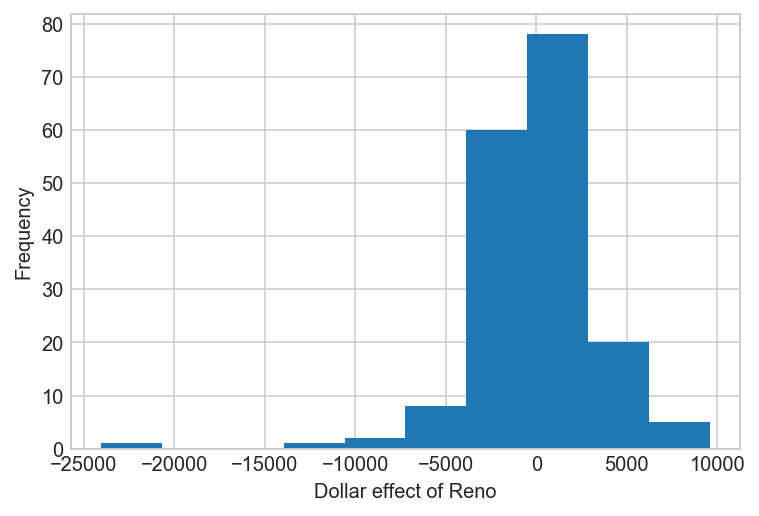

In [36]:
df['dollar_effect_reno'].plot(kind = 'hist')
plt.xlabel('Dollar effect of Reno');

**We see that model 2 only explains around 12%(From training data) of the difference in price(residuals)** 
**Look at the graph below. If we use arbitary reno price of $20,000, we see that no point in renovating to sell as we would make a loss!**

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [37]:
# A:
#Lets use house4 to play with the datset,so that we do not screw up the original
house4 =house2.copy()

#Check out SaleCondition
print house4['SaleCondition'].value_counts()
print 'Abnormal seems to only make up a small percentage at {}%'.format(101.0/len(house2['SaleCondition']) *100)

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64
Abnormal seems to only make up a small percentage at 6.91780821918%


** Upsample dataset to deal with abnormal data**

In [38]:
# Change Abnormal to 1, the rest to 0s
house4['SaleCondition'] = (house2['SaleCondition'] == 'Abnorml').astype(int)

In [39]:
#Split into abnormal and not abnormal
majority = house4[house4['SaleCondition']==0] 
minority = house4[house4['SaleCondition']==1] 


from sklearn.utils import resample
minority_upsampled = resample(minority, replace=True, n_samples= len(majority), random_state=123)

# Combine majority class with upsampled minority class
total_upsampled = pd.concat([majority, minority_upsampled])

#Check out the difference.
total_upsampled['SaleCondition'].value_counts()

1    1359
0    1359
Name: SaleCondition, dtype: int64

In [48]:
#Check out the shape
total_upsampled.shape

#Dummycode columns as log regression cant take strings
dummycoded_upsampled = pd.get_dummies(total_upsampled, drop_first = True)

dummycoded_upsampled.shape

(2718, 344)

In [51]:
X = dummycoded_upsampled.drop('SaleCondition',axis =1)

#Scale X
Standardized_X = StandardScaler().fit_transform(X)


y = dummycoded_upsampled['SaleCondition']

#Split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [78]:
#Use log regression
from sklearn.linear_model import LogisticRegressionCV
logregcv = LogisticRegressionCV()
logregcv.fit(X_train,y_train)
print 'cross validated training score: ',logregcv.score(X_train,y_train)

cross validated training score:  0.6540938362465502


In [97]:
#Check out which coefficents classifies well
predictors_coef = (logregcv.fit(X_train,y_train).coef_)[0]
predictors = X.columns
predictors
predictor_with_score = zip(predictors, predictors_coef)
df =pd.DataFrame(predictor_with_score,columns = ['predictors', 'coefs'])


#Return top 10 predictors regardless positive or negative
df['abs_coefs'] = df['coefs'].abs()
df.sort_values('abs_coefs',axis =0, ascending =False).head(10)

,predictors,coefs,abs_coefs
35,PoolArea,0.010174,0.010174
34,ScreenPorch,0.002987,0.002987
32,EnclosedPorch,0.002728,0.002728
0,MSSubClass,-0.002623,0.002623
39,MiscVal,-0.001938,0.001938
4,YearBuilt,0.001695,0.001695
7,LotFrontage,0.001328,0.001328
17,LowQualFinSF,0.001206,0.001206
5,YearRemodAdd,-0.001048,0.001048
18,GrLivArea,0.000988,0.000988


In [ ]:
#Predict on test set
y_pred = logregcv.predict(X_test)
print 'predicted score:' , logregcv.score(X_test, y_test)

In [64]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[162 113]
 [ 86 183]]


In [99]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.65      0.59      0.62       275
          1       0.62      0.68      0.65       269

avg / total       0.64      0.63      0.63       544



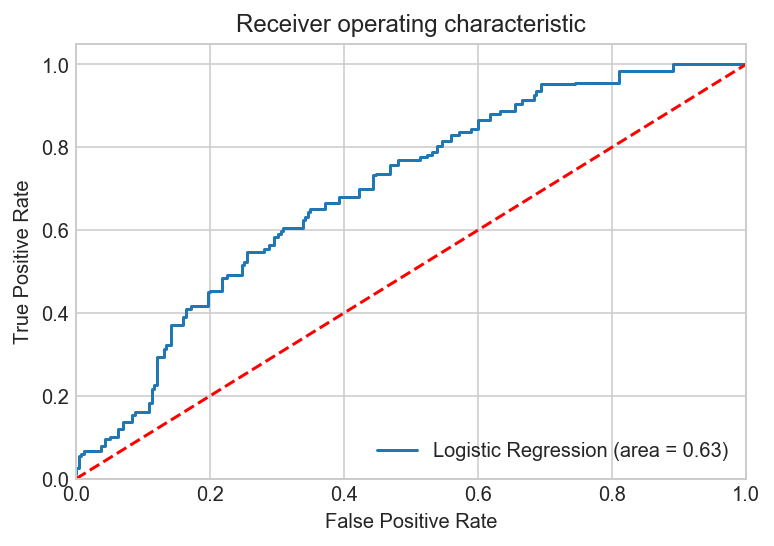

In [101]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregcv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregcv.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()